In [1]:
import pylab as plt
import xarray as xr
import pint_xarray
from pathlib import Path
import numpy as np

from pism_ragis.observations import load_imbie, load_mouginot

In [25]:
    mass_cumulative_varname = "Cumulative ice sheet mass change (Gt)"
    mass_cumulative_uncertainty_varname = (
        "Cumulative ice sheet mass change uncertainty (Gt)"
    )
    mass_flux_varname = "Rate of ice sheet mass change (Gt/yr)"
    mass_flux_uncertainty_varname = "Rate of ice sheet mass change uncertainty (Gt/yr)"

    discharge_cumulative_varname = "Cumulative ice discharge anomaly (Gt)"
    discharge_cumulative_uncertainty_varname = (
        "Cumulative ice discharge anomaly uncertainty (Gt)"
    )
    discharge_flux_varname = "Rate of ice discharge (Gt/yr)"
    discharge_flux_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"

    smb_cumulative_varname = "Cumulative surface mass balance anomaly (Gt)"
    smb_cumulative_uncertainty_varname = (
        "Cumulative surface mass balance anomaly uncertainty (Gt)"
    )
    smb_flux_varname = "Rate of surface mass balance (Gt/yr)"
    smb_flux_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

    basal_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux"

    sim_mass_cumulative_varname = "ice_mass"
    sim_mass_flux_varname = "tendency_of_ice_mass"
    sim_smb_flux_varname = "tendency_of_ice_mass_due_to_surface_mass_flux"
    sim_discharge_flux_varname = "ice_mass_transport_across_grounding_line"


In [10]:
mouginot_url = Path("/mnt/storstrommen/data/mouginot/pnas.1904242116.sd02.xlsx")

# Load observations
imbie = load_imbie()
mou = load_mouginot(url=mouginot_url, norm_year=1980)
mou[discharge_flux_varname] = -mou[discharge_flux_varname]
mou_gis = mou[mou["Basin"] == "GIS"]

imbie_mean = imbie[imbie.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,
    ]
].mean()
mou_mean = mou[mou.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,        ]
].mean()
u_ratio = imbie_mean / mou_mean / 2
sigma_adjusted = np.maximum(u_ratio, 1)

In [11]:
sigma_adjusted

Rate of ice sheet mass change uncertainty (Gt/yr)     2.238989
Rate of surface mass balance uncertainty (Gt/yr)      2.886524
Rate of ice discharge uncertainty (Gt/yr)            10.434424
dtype: float64

In [38]:
ds_ctrl = xr.open_mfdataset("analysis/2024_07_ragis_ctrl/basins_sums_ensemble_RAGIS_id_BM-*.nc").pint.quantify()
ds_ctrl = ds_ctrl.sel(ensemble_id="RAGIS")
ds_ctrl[sim_mass_cumulative_varname] -= ds_ctrl.sel(time="1980-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_ctrl = ds_ctrl.rolling(time=13).mean()

In [39]:
ds_tw = xr.open_mfdataset("analysis/2024_07_ragis_tw/basins_sums_ensemble_RAGIS_id_BM-*.nc").pint.quantify()
ds_tw = ds_tw.sel(ensemble_id="RAGIS")
ds_tw[sim_mass_cumulative_varname] -= ds_tw.sel(time="1980-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_tw = ds_tw.rolling(time=13).mean()

In [40]:
ds_tw_scalar = xr.open_mfdataset("/mnt/storstrommen/ragis/data/pism/2024_06_ragis_tw/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BM-FR-SC-1.1-VCM-0.45_1975-1-1_2020-1-1.nc").pint.quantify()
ds_tw_scalar = ds_tw_scalar.rolling(time=13).mean()
ds_tw_scalar[[sim_mass_cumulative_varname, "limnsw"]] -= ds_tw_scalar.sel(time="1980-01-01", method="nearest")[[sim_mass_cumulative_varname, "limnsw"]]

(3652.0, 18262.0)

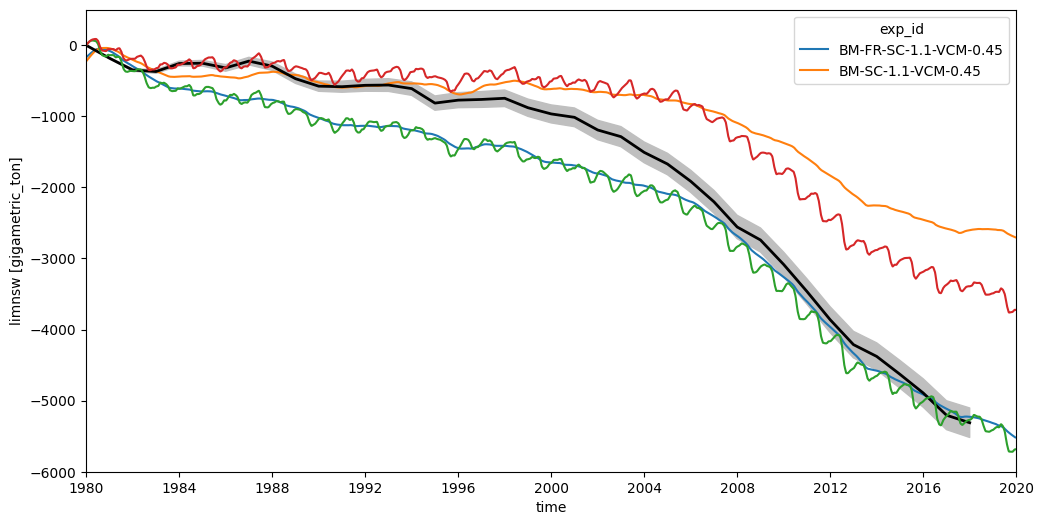

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
ds_tw.sel(basin="GIS")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)
ds_tw_scalar[sim_mass_cumulative_varname].pint.to("Gt").plot.line(ax=ax)
ds_tw_scalar["limnsw"].pint.to("Gt").plot.line(ax=ax)
ax.set_ylim(-6000, 500)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

(3652.0, 18262.0)

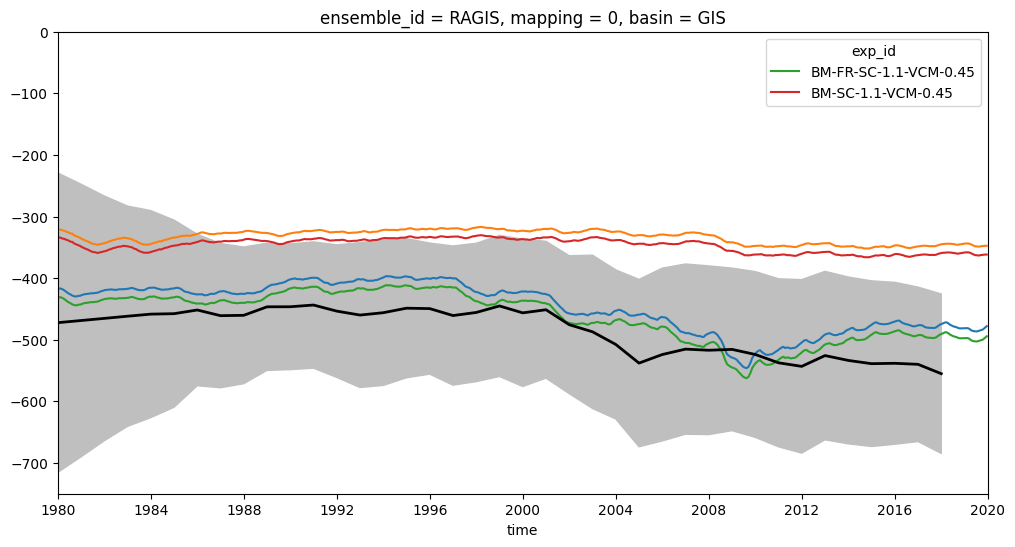

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname].plot.line(x="time", hue="exp_id", ax=ax)
ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].plot.line(x="time", hue="exp_id", ax=ax)
(ds_tw.sel(basin="GIS")["tendency_of_ice_mass_due_to_basal_mass_flux_grounded"] + ds_tw.sel(basin="GIS")[sim_discharge_flux_varname]).plot.line(x="time", hue="exp_id", ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[discharge_flux_varname] - sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], 
                mou_gis[discharge_flux_varname] + sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Rate of ice discharge (Gt/yr)"], color="k", lw=2)
ax.set_ylim(-750, 0)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

(3652.0, 18262.0)

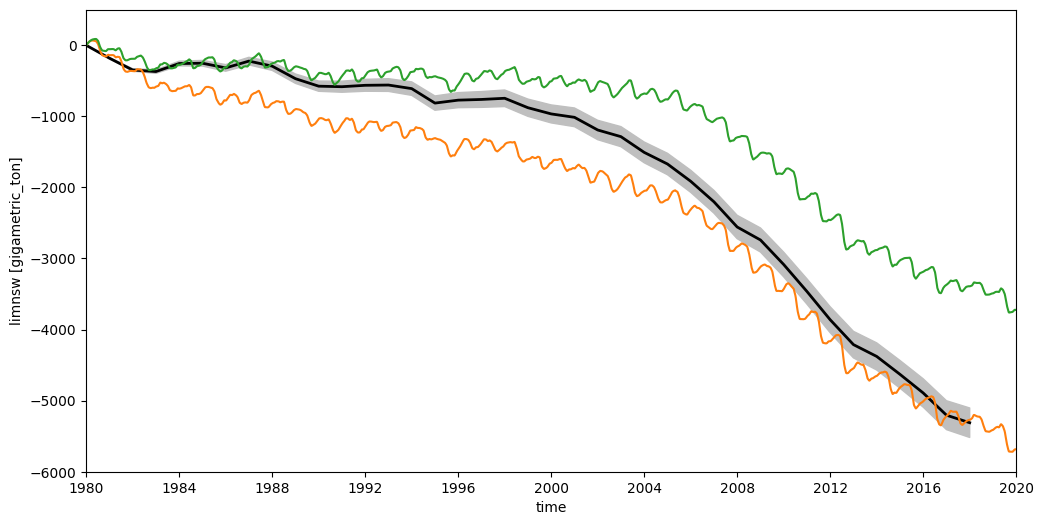

In [71]:
mb = (ds_tw["tendency_of_ice_mass_due_to_surface_mass_flux"] + ds_tw["ice_mass_transport_across_grounding_line"]).cumsum()
#mb -= mb.sel(time="1980-01-01", method="nearest")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
# ds_tw.sel(basin="GIS")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)
ds_tw_scalar[sim_mass_cumulative_varname].pint.to("Gt").plot.line(ax=ax)
ds_tw_scalar["limnsw"].pint.to("Gt").plot.line(ax=ax)
ax.set_ylim(-6000, 500)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

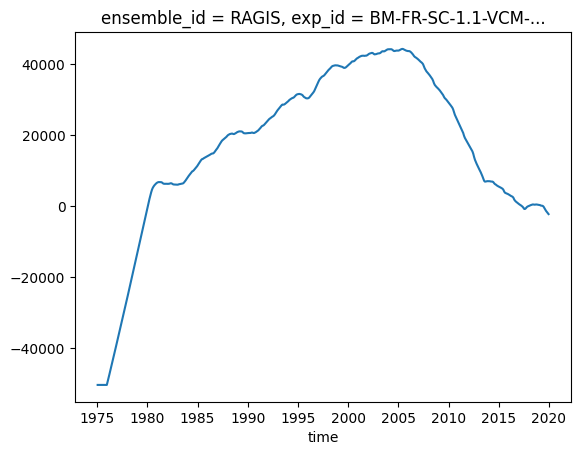

In [61]:
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line()

# ds.data_vars

In [78]:
ds_tw.data_vars

Data variables:
    ice_mass                                              (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    ice_mass_transport_across_grounding_line              (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass                                  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux           (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux_grounded  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux_floating  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_discharge                 (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1,

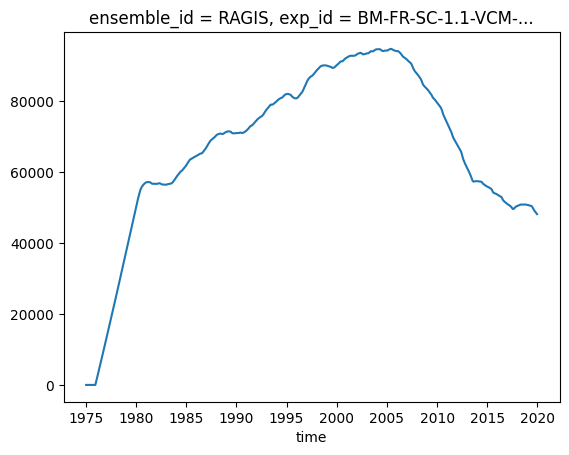

In [72]:
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot()

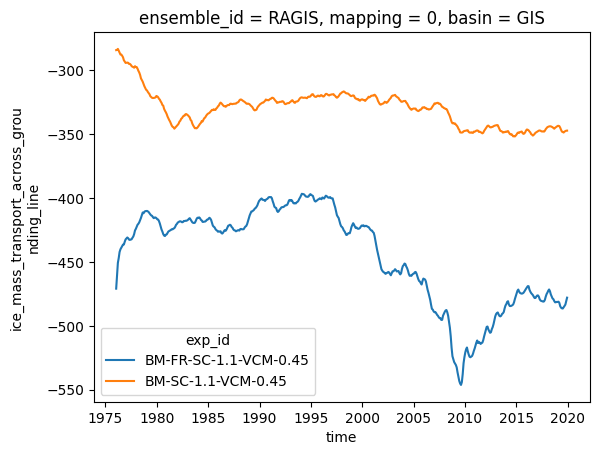

In [73]:
ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].plot(hue="exp_id")

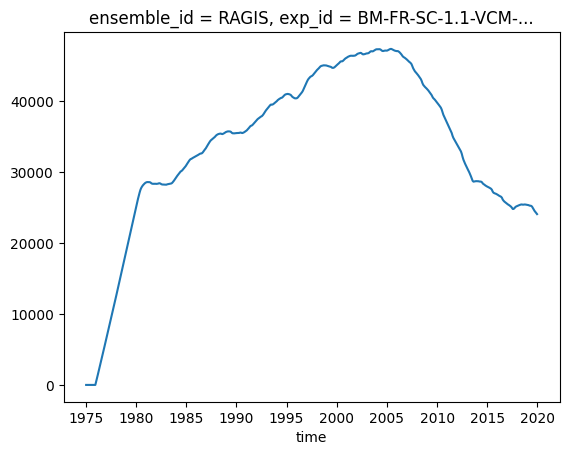

In [76]:
(ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname] + ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")["tendency_of_ice_mass_due_to_surface_mass_flux"]).cumsum().plot()